### Imports

In [1]:
import os
import time
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dotenv import dotenv_values
from torchvision.io import read_image
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR
from env_enum import TargetEnvKeys, ModelEnvKeys
from torchvision.models import resnet34, ResNet34_Weights
from torch.utils.data import Dataset, DataLoader, sampler

### Global vars

In [2]:
random_seed = 42
dtype = torch.float32
env_path = "../.env"

### Random Seed Setup

In [3]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

### Device Setup

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")

Device in use: cuda


### Dataset class definition

In [5]:
class PlaneDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.to_pil = T.ToPILImage()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = self.to_pil(image).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

### Data reference

In [6]:
env_config = dotenv_values(env_path)

data_key = TargetEnvKeys.DATA_TARGET_DIR.value
train_img_dir = env_config[data_key]

label_key = TargetEnvKeys.LABEL_TARGET_DIR.value
labels_csv_path = env_config[label_key]

### Dataset setup

In [7]:
preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = PlaneDataset(labels_csv_path, train_img_dir, preprocess)

### Train and Validation datasets configuration

In [8]:
dataset_size = len(train_dataset)
val_size = int(dataset_size * 0.1)
train_size = dataset_size - val_size

indices = list(range(dataset_size))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

### Hyperparameters definiton

In [9]:
batch_size = 32
learning_rate = 1e-3
momentum = 9e-1
num_epochs = 10
step_size = 4
gamma = 0.1

### Data loaders setup

In [10]:
generator = torch.Generator().manual_seed(random_seed)

train_sampler = sampler.SubsetRandomSampler(train_indices, generator=generator)
val_sampler = sampler.SubsetRandomSampler(val_indices, generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

data_loaders = {"train":train_dataloader, "val":val_dataloader}
data_sizes = {"train":train_size, "val":val_size}

### Dataset sample examples

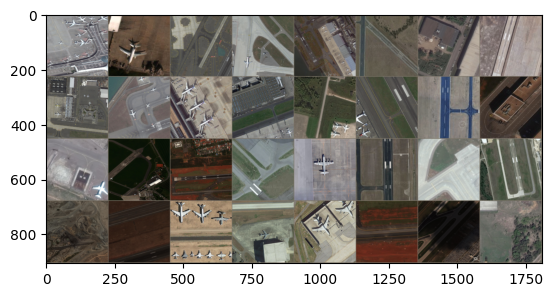

In [11]:
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(data_loaders["train"]))

out = torchvision.utils.make_grid(inputs)

imshow(out)

### Model definition

In [12]:
model = resnet34(weights=ResNet34_Weights.DEFAULT)

num_classes = 2
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

model = model.to(device=device)

### Loss function, Optimization method, LearningRate scheduler  setup

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

### Train method definition

In [14]:
def train(num_epochs, model, data_loaders, data_sizes, optimizer, criterion, device, dtype):
    metrics = {
        "train": {"loss": list(), "accuracy": list()},
        "val": {"loss": list(), "accuracy": list()},
    }
    
    optimal_result = {
        "epoch": 0,
        "accuracy": -1
    }
    
    resnet34_weights_key = ModelEnvKeys.RESNET34_WEIGHTS_PATH.value
    resnet34_weights_path = env_config[resnet34_weights_key]
    torch.save(model.state_dict(), resnet34_weights_path)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch: {epoch + 1}/{num_epochs}")
        print("-" * 45)
        
        for mode in ["train", "val"]:

            if mode == "train":
                model.train()
            else:
                model.eval()

            running_accuracy = 0
            loss_history = []

            for inputs, labels in data_loaders[mode]:
                inputs = inputs.to(device=device, dtype=dtype)
                labels = labels.to(device=device, dtype=torch.long)

                with torch.set_grad_enabled(mode == "train"):
                    optimizer.zero_grad()
                    output = model(inputs)
                    pred_labels = torch.argmax(output, axis=1)
                    loss = criterion(output, labels)

                    if mode == "train":
                        loss.backward()
                        optimizer.step()

                    running_accuracy += (pred_labels == labels).sum()
                    loss_history.append(loss.item())

            epoch_accuracy = running_accuracy / data_sizes[mode]
            epoch_loss = torch.tensor([loss_history]).mean()

            metrics[mode]["loss"].append(epoch_loss.item())
            metrics[mode]["accuracy"].append(epoch_accuracy.item())
            
            if mode == "val" and epoch_accuracy > optimal_result["accuracy"]:
                optimal_result["accuracy"] = epoch_accuracy
                optimal_result["epoch"] = epoch + 1
                torch.save(model.state_dict(), resnet34_weights_path)

            print(f"{mode} Accuracy: {epoch_accuracy:.4f}%, {mode} Loss: {epoch_loss:.4f}")
        
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
        scheduler.step()
            
    return metrics, optimal_result

In [15]:
metrics, optimal_result = train(num_epochs, model, data_loaders, data_sizes, optimizer, criterion, device, dtype)


Epoch: 1/10
---------------------------------------------
train Accuracy: 0.7372%, train Loss: 0.5194
val Accuracy: 0.8210%, val Loss: 0.3863
Learning rate: 0.001

Epoch: 2/10
---------------------------------------------
train Accuracy: 0.9049%, train Loss: 0.2313
val Accuracy: 0.8395%, val Loss: 0.3489
Learning rate: 0.001

Epoch: 3/10
---------------------------------------------
train Accuracy: 0.9555%, train Loss: 0.1304
val Accuracy: 0.8457%, val Loss: 0.2907
Learning rate: 0.001

Epoch: 4/10
---------------------------------------------
train Accuracy: 0.9713%, train Loss: 0.0855
val Accuracy: 0.8642%, val Loss: 0.2883
Learning rate: 0.001

Epoch: 5/10
---------------------------------------------
train Accuracy: 0.9671%, train Loss: 0.0883
val Accuracy: 0.8457%, val Loss: 0.4869
Learning rate: 0.001

Epoch: 6/10
---------------------------------------------
train Accuracy: 0.9890%, train Loss: 0.0456
val Accuracy: 0.8457%, val Loss: 0.5195
Learning rate: 0.0001

Epoch: 7/10
--

In [16]:
print(f"Optimal Epoch: {optimal_result['epoch']}")
print(f"Optimal Accuracy: {optimal_result['accuracy']:.4f}%")

Optimal Epoch: 4
Optimal Accuracy: 0.8642%


### Metrics Plots

In [17]:
epochs = range(1, epochs + 1)
train_loss = metrics["train"]["loss"]
val_loss = metrics["val"]["loss"]
train_acc = metrics["train"]["accuracy"]
val_acc = metrics["val"]["accuracy"]

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'epochs' is not defined